In [10]:
import datetime as dt
import difflib
import json
import math
import os
import string
import sys
from datetime import timedelta
from random import sample

import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pyreadstat
import seaborn as sns
import statsmodels.tools.tools as sm
import statsmodels.base as sb
from folium.features import CustomIcon
from folium.plugins import FastMarkerCluster, HeatMap, MarkerCluster
from linearmodels.panel.model import PooledOLS
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import aic, rmse
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
from yahoofinancials import YahooFinancials
import pickle

In [11]:
with open('DataFrameDict_Hsa3.pickle', 'rb') as f:
     DataFrameDict_Hsa3 =  pickle.load(f)
        

In [12]:
def selectStationaySeries2(variable_tar):
    count1 = np.isinf(variable_tar.pct_change(1)).values.sum()
    count2 = np.isinf(variable_tar.pct_change(1)).values.sum()
    
    if adfuller(variable_tar.interpolate("bfill").interpolate("ffill"))[1] < threshold:
            stationary_variable = variable_tar.interpolate("bfill").interpolate("ffill")
            suffix =  "original"
            print(suffix)
            return(pd.DataFrame(stationary_variable))
    
    
    elif count1 == 0:
        try:
            if adfuller(variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill")
                suffix = "1storderdiff"
                print(suffix)
                return(pd.DataFrame(stationary_variable))
        except np.linalg.LinAlgError as e1:
            print('except:', e1)
    
    
    elif count2 == 0:
        try: 
            if adfuller(variable_tar.pct_change(1).diff().dropna(how="all"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).diff().dropna(how="all")
                suffix = "2ndorderdiff"
                print(suffix)
                return(pd.DataFrame(stationary_variable))
        except np.linalg.LinAlgError as e1:
            print('except:', e1)     
    
    else:
        print('not found')

In [13]:
def person_cat_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDAp[key][lst1]
            .astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def house_cat_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDA[key][lst1].astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def person_num_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDAp[key][lst1]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def house_num_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDA[key][lst1]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def HILDAext_cat_all(lst1, lst2):
    dfHILDA1 = house_cat_all( lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_cat_all(lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
def HILDAext_num_all( lst1, lst2):
    dfHILDA1 = house_num_all(lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_num_all(lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
lst_age = [f'hgdob{i}' for i in range(1, 21)]
def HILDAext_age_all():    
    df_tmp = pd.DataFrame()
    for key in DataFrameDict_HILDA.keys():
        df = DataFrameDict_HILDA[key][lst_age]
        df["date"] = str(key)
        df = df.melt(id_vars='date', var_name='Indicator name', value_name='birth_date').sort_values('date', ascending=False).reset_index(drop=True)
        df['birthDate'] = pd.to_datetime(df['birth_date'].replace(r'-','na',regex=True),errors = 'coerce')
        df['year'] = pd.DatetimeIndex(df['birthDate']).year
        df['age'] = key +1 - df['year']
        df_tmp = pd.concat([df_tmp, df[['date','age']]], axis=0, ignore_index=True)
    f = {'age': ['median', 'std', q1, q3,'count']} 
    dfHILDAage = df_tmp.groupby('date').agg(f)
    dfHILDAage = dfHILDAage.set_axis(dfHILDAage.columns.map(''.join), axis=1, inplace=False).reset_index()
    dfHILDAage["date"] = pd.to_datetime(dfHILDAage["date"]) + pd.offsets.YearEnd()
    return dfHILDAage

In [14]:
varnames_catp = ["ancob", "edhigh1", "anatsi", "chkb12", "sex"]
# varnames_nump = ["wsce", "baynoa"]
varnames_nump = ["wsce"]
varnames_cath = []
#varnames_cath = ["xpgroci"]
varnames_numh = ["hsdebt"]

year = list(range(2001, 2021))

DataFrameDict_HILDA = {elem: pd.DataFrame for elem in year}
for key in DataFrameDict_HILDA.keys():
    order = key - 2001
    ini = string.ascii_lowercase[order]
    df, meta = pyreadstat.read_dta(f"Household_{ini}200u.dta")
    df.columns = df.columns.str[1:]
    DataFrameDict_HILDA[key] = df




In [16]:
DataFrameDict_HILDAp = {elem: pd.DataFrame for elem in year}
for key in DataFrameDict_HILDAp.keys():
    order = key - 2001
    ini = string.ascii_lowercase[order]
    df, meta = pyreadstat.read_dta(f"Rperson_{ini}200u.dta")
    df.columns = df.columns.str[1:]
    DataFrameDict_HILDAp[key] = df

In [18]:
import re


def nan_dum(df):
    df1_ohe = df
    nan_df = df1_ohe.loc[:, df1_ohe.columns.str.endswith("_nan")]
    pattern = "^([^_]*)_"
    regex = re.compile(pattern)
    for index in df1_ohe.index:
        for col_nan in nan_df.columns:
            if df1_ohe.loc[index, col_nan] == 1:
                col_id = regex.search(col_nan).group(1)
                targets = df1_ohe.columns[df1_ohe.columns.str.startswith(col_id + "_")]
                df1_ohe.loc[index, targets] = np.nan
    df1_ohe.drop(
        df1_ohe.columns[df1_ohe.columns.str.endswith("_nan")], axis=1, inplace=True
    )
    return df1_ohe

In [20]:
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

In [21]:
HILDAextract_num_all = HILDAext_num_all(varnames_numh, varnames_nump)
HILDAextract_cat_all = HILDAext_cat_all(varnames_cath, varnames_catp)
HILDAextract_age_all = HILDAext_age_all()
HILDAextract_all = pd.merge(HILDAextract_num_all, HILDAextract_cat_all, on="date", how="left")
HILDAextract_all = pd.merge( HILDAextract_all , HILDAextract_age_all, on="date", how="left")
df_tmp = HILDAextract_all
dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=True)})
list1, list2 = zip(*dfHILDA.columns)
dfHILDA.columns = list1

In [22]:
dfHILDA = dfHILDA.reset_index()    

In [23]:
def selectStationaySeries3(variable_tar):
    count1 = np.isinf(variable_tar.pct_change(1)).values.sum()
    count2 = np.isinf(variable_tar.pct_change(1)).values.sum()
    
    if adfuller(variable_tar.interpolate("bfill").interpolate("ffill"))[1] < threshold:
            stationary_variable = variable_tar.interpolate("bfill").interpolate("ffill")
            suffix =  "original"
            print(suffix)
            return(pd.DataFrame(stationary_variable))
    
    
    elif count1 == 0:
        try:
            if adfuller(variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill")
                suffix = "1storderdiff"
                print(suffix)
                return(pd.DataFrame(stationary_variable))
        except np.linalg.LinAlgError as e1:
            print('except:', e1)
    
    
    elif count2 == 0:
        try: 
            if adfuller(variable_tar.pct_change(1).diff().dropna(how="all"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).diff().dropna(how="all")
                suffix = "2ndorderdiff"
                print(suffix)
                return(pd.DataFrame(stationary_variable))
        except np.linalg.LinAlgError as e1:
            print('except:', e1)     
    
    else:
        print('not found')

In [228]:
def datasetcut(df):
    lst_whole = list(df.columns)
    result_ancob = [i for i in lst_whole if i.startswith('ancob_')]
    list_ancob0 = ['1101', '2100', '1201', '7103', '5204', '6101', '9225', '5105', '2308']
    list_ancob =  ['ancob_' + sub for sub in list_ancob0]
    result_edhigh = [i for i in lst_whole if i.startswith('edhigh1_')]
    list_edhigh0= ['1','2','3','4','5','8','9']
    list_edhigh =  ['edhigh1_' + sub for sub in list_edhigh0]
    result_anatsi = [i for i in lst_whole if i.startswith('anatsi_')]
    list_anatsi0= ['1','2','3','4']
    list_anatsi =  ['anatsi_' + sub for sub in list_anatsi0]
    result_chkb =  [i for i in lst_whole if i.startswith('chkb12_')]
    list_chkb0= ['1','2','3','4']
    list_chkb =  ['chkb12_' + sub for sub in list_chkb0]
    list_deleted =  [i for i in lst_whole if i.startswith(('ancob_','edhigh1_','chkb12_','anatsi_'))]
    list_remained = [vn for vn in lst_whole if vn not in list_deleted]
    list_final = list_remained + list_ancob + list_edhigh + list_anatsi + list_chkb
    return df[list_final]
    

In [229]:
dfHILDA_cut =  datasetcut(dfHILDA)

In [231]:
threshold = 0.01
df = dfHILDA_cut.set_index("date")
df1 = df.resample("Y").mean().iloc[:, :]
vrst = pd.DataFrame([])

# need a dataframe to writedown the way to stabilize all variables
df_marks = pd.DataFrame([],
                   columns=['Variable Names', 'Approach'])


for vn in df1.columns.values[1:]:
    
    variable_tar = df1[vn]
    
    count1 = np.isinf(variable_tar.pct_change(1)).values.sum()
    count2 = np.isinf(variable_tar.pct_change(1)).values.sum()
    
    if adfuller(variable_tar.interpolate("bfill").interpolate("ffill"))[1] < threshold:
            stationary_variable = variable_tar.interpolate("bfill").interpolate("ffill")
            suffix =  "original"
            new_row = {'Variable Names': vn,'Approach': suffix}
            df_marks = df_marks.append(new_row, ignore_index=True)
            newseries = pd.DataFrame(stationary_variable)
            vrst = pd.concat([vrst, newseries], axis=1)

    
    
    elif count1 == 0:
        try:
            if adfuller(variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill")
                suffix = "1storderdiff"
                new_row = {'Variable Names': vn,'Approach': suffix}
                df_marks = df_marks.append(new_row, ignore_index=True)
                newseries = pd.DataFrame(stationary_variable)
                vrst = pd.concat([vrst, newseries], axis=1)

        except np.linalg.LinAlgError as e1:
            print('except:', e1)
    
    
    elif count2 == 0:
        try: 
            if adfuller(variable_tar.pct_change(1).diff().dropna(how="all"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).diff().dropna(how="all")
                suffix = "2ndorderdiff"
                new_row = {'Variable Names': vn,'Approach': suffix}
                df_marks = df_marks.append(new_row, ignore_index=True)
                newseries = pd.DataFrame(stationary_variable)
                vrst = pd.concat([vrst, newseries], axis=1)

        except np.linalg.LinAlgError as e1:
            print('except:', e1)     
    
    else:
        print('not found')

    
    
vrdata = vrst.reset_index()
    
pca = PCA()
X_train = vrdata.loc[:, vrdata.columns != "date"]
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

pca.fit(X_train_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d2 = np.argmax(cumsum >= 0.9) + 1
print(d2)

pca_d_sa3 = PCA(n_components=d2)
pca_d_sa3.fit(X_train_std)
X_pca_d_sa3 = pca_d_sa3.transform(X_train_std)

PCnames = []
for i in range(1, d2 + 1, 1):
    PCnames.append(f"sa3PC{i}")
    
pcadf = pd.DataFrame(X_pca_d_sa3, columns=PCnames)
pcadf['date'] = dfHILDA['date']  
pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
pcadf_sa3_date = pcadf

6


In [239]:
vrdata

,date,agemedian,agestd,ageq3,agecount,ancob_1101,ancob_1201,ancob_7103,ancob_6101,ancob_9225,ancob_5105,edhigh1_5,edhigh1_8,edhigh1_9,anatsi_1
0,2001-12-31,35.0,-0.000956,0.000000,-0.036899,0.745365,-0.042136,-0.085943,-0.247637,-0.010194,0.009235,0.172883,-0.013446,-0.031794,0.024739
1,2002-12-31,35.0,-0.000956,0.000000,-0.036899,0.762902,-0.042136,-0.085943,-0.247637,-0.010194,0.008742,0.177900,-0.013446,-0.031794,0.024739
2,2003-12-31,35.0,-0.002061,0.000000,0.131769,0.774277,-0.063545,0.056610,0.111421,-0.171906,0.006914,0.182904,0.024591,-0.029979,0.013515
3,2004-12-31,35.0,0.004439,0.000000,-0.029141,0.780061,0.029813,-0.036379,-0.022294,0.008404,0.006931,0.184317,-0.003534,-0.021997,0.007320
4,2005-12-31,36.0,0.003335,0.019231,-0.004424,0.783447,-0.008516,0.019546,0.068145,0.173695,0.006348,0.188103,-0.001012,-0.029121,0.001763
5,2006-12-31,36.0,0.003693,0.000000,-0.026088,0.787757,-0.018890,0.079950,-0.129366,-0.039562,0.006277,0.190469,0.008093,-0.015619,0.005166
6,2007-12-31,36.0,0.007078,0.000000,-0.026002,0.795762,-0.022098,-0.061991,-0.042238,-0.050287,0.006099,0.193213,0.030596,-0.027081,0.009070
7,2008-12-31,36.0,0.004404,0.018868,-0.000957,0.798279,0.032195,-0.045156,0.000313,-0.015317,0.006023,0.194134,0.006937,-0.018704,0.002743
8,2009-12-31,36.0,0.002307,0.000000,0.017949,0.798211,0.009452,0.037492,0.064192,-0.008280,0.006165,0.199759,0.030767,-0.026517,-0.003665
9,2010-12-31,36.0,-0.002383,0.000000,0.014264,0.801419,-0.002173,0.026749,-0.032495,0.059009,0.006210,0.203312,0.014922,-0.026257,0.003479


In [234]:
marks1 = df_marks['Variable Names'].loc[df_marks['Approach'] == 'original'].values
marks2 = df_marks['Variable Names'].loc[df_marks['Approach'] == "1storderdiff"].values
marks3 = df_marks['Variable Names'].loc[df_marks['Approach'] == "2ndorderdiff"].values
def selectStationaySeries3(variable_tar, vn, marks):
    
    count1 = np.isinf(variable_tar.pct_change(1)).values.sum()
    count2 = np.isinf(variable_tar.pct_change(1)).values.sum()
    marks1 =marks['Variable Names'].loc[marks['Approach'] == 'original'].values
    marks2 =marks['Variable Names'].loc[marks['Approach'] == "1storderdiff"].values
    marks3 =marks['Variable Names'].loc[marks['Approach'] == "2ndorderdiff"].values
    
    if vn in marks1:
            stationary_variable = variable_tar.interpolate("bfill").interpolate("ffill")
            suffix =  "original"
            #print(suffix)
            return(pd.DataFrame(stationary_variable))
    
    
    elif count1 == 0 and vn in marks2:
        try:
            if adfuller(variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill")
                suffix = "1storderdiff"
                #print(suffix)
                return(pd.DataFrame(stationary_variable))
        except np.linalg.LinAlgError as e1:
            print('except:', e1)
    
    
    elif count2 == 0 and vn in marks3:
        try: 
            if adfuller(variable_tar.pct_change(1).diff().dropna(how="all"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).diff().dropna(how="all")
                suffix = "2ndorderdiff"
                #print(suffix)
                return(pd.DataFrame(stationary_variable))
        except np.linalg.LinAlgError as e1:
            print('except:', e1)     
    
    else:
        print('not found')

In [235]:
def HILDA2PCsa3(key, marks):
    df = DataFrameDict_Hsa3[key].interpolate("bfill").interpolate("ffill")
    df = df.set_index("date")
    df1 = df.resample("Y").mean().iloc[:, :]
    
    vrst = pd.DataFrame([])
    for vn in df1.columns.values[1:]:
        vrst = pd.concat([vrst, selectStationaySeries3(df1[vn], vn, marks)], axis=1)
    vrdata = vrst.reset_index()
    
    pca = PCA()
    X_train = vrdata.loc[:, vrdata.columns != "date"]
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    pca.fit(X_train_std)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.9) + 1
    print(d)

    pca_d = PCA(n_components=d)
    pca_d.fit(X_train_std)
    X_pca_d = pca_d.transform(X_train_std)
    PCnames = []
    for i in range(1, d + 1, 1):
        PCnames.append(f"sa3PC{i}")
    pcadf = pd.DataFrame(X_pca_d, columns=PCnames)
    pcadf['date'] = DataFrameDict_Hsa3[key]['date']  
    pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
    pcadf["date"] = pcadf["date"]
    return pcadf

In [236]:
def HILDAvarExt(key, marks):
    df = DataFrameDict_Hsa3[key].interpolate("bfill").interpolate("ffill")
    df = df.set_index("date")
    df1 = df.resample("Y").mean().iloc[:, :]
    vrst = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list( set(df_marks['Variable Names'].values) & set(df1.columns.values[1:]))
    for vn in lst:
        vrst[vn] = selectStationaySeries3(df1[vn], vn, marks)
    vrdata = vrst.reset_index().fillna(value = 0) 
    return(vrdata)

In [237]:
def PCA_val(gamma1,marks,vrdata):
    tmp = pd.DataFrame([], columns = marks['Variable Names'].values)
    for key in DataFrameDict_Hsa3.keys(): 
        df = HILDAvarExt(key,marks)
        df1= df[vrdata.columns.tolist()]
        df2 = df1.drop(df1.columns[0], axis=1)
        
        vrdata1 = vrdata.drop(vrdata.columns[0],axis=1)
        vrdata2= vrdata1.apply(lambda x: x*gamma1)
        
        df_add = df2.add(vrdata2, fill_value=0)
        tmp = pd.concat([tmp, df_add],axis = 0)
        
    pca = PCA()
    X_train = tmp
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    pca.fit(X_train_std)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d2 = np.argmax(cumsum >= 0.9) + 1


    pca_d_sa3 = PCA(n_components=d2)
    pca_d_sa3.fit(X_train_std)
    X_pca_d_sa3 = pca_d_sa3.transform(X_train_std)

    PCnames = []
    for i in range(1, d2 + 1, 1):
        PCnames.append(f"sa3PC{i}")
    
    pcadf = pd.DataFrame(X_pca_d_sa3, columns=PCnames)
    pcadf_sa3_date = pcadf
    return  d2, pca_d_sa3
        

In [295]:
PCnumbers = []
x = [0,0.5,1,2,5,10,20,30,40,50,60,70,80,90,100,200]
for gamma in x:
    gamma1 = gamma
    d2, pcafit = PCA_val(gamma1,df_marks,vrdata)
    PCnumbers.append(d2)
    print(gamma)


not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
0
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
0.5
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
1
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
2
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
5
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
10
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
20
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
30
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
40
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
50
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
60
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
70
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
80
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
90
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
100
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
200


(array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

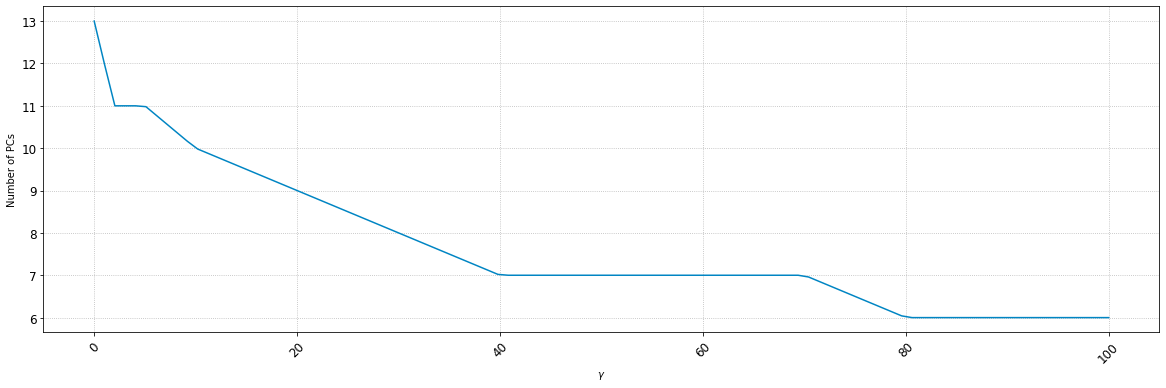

In [300]:
from scipy.interpolate import make_interp_spline, BSpline
# represents number of points to make between x.min and x.max
xnew =np.concatenate((np.linspace(0, 50, 50), np.linspace(50, 100, 50)))
spl = make_interp_spline(x, PCnumbers, k=1)  # type: BSpline
PCno_smooth = spl(xnew)

color1 = "#0085c3"
color2 = "#7ab800"
color3 = "#dc5034"

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)
ax.plot(xnew, PCno_smooth , color=color1)
ax.grid(ls=":", color="gray", alpha=0.6)

plt.xlabel(r'$\gamma$')
plt.ylabel('Number of PCs')


plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

In [297]:
PCnumbers

[13, 12, 12, 11, 11, 10, 9, 8, 7, 7, 7, 7, 6, 6, 6, 6]

In [242]:
lambdaindexList = []
for i in range(13,6,-1):
   aa = min([index for index,value in enumerate(PCno_smooth) if int(value)  == i])
   lambdaindexList.append(aa)
lambdaList = xnew[lambdaindexList]

In [243]:
lambdaList 

array([ 0.        ,  0.10012516,  0.50062578,  2.00250313, 10.01251564,
       20.02503129, 34.84355444])

In [256]:
vrdata = vrst.reset_index()
gamma1 =  0;
d3, pcafit = PCA_val(gamma1,df_marks,vrdata)
X_pca_d_sa3_new = pcafit.transform(X_train_std)

not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


In [252]:
PCnames = []
for i in range(1, d3 + 1, 1):
    PCnames.append(f"sa3PC{i}")
    
pcadf = pd.DataFrame(X_pca_d_sa3_new , columns=PCnames)



In [253]:
pcadf['date'] = dfHILDA['date']  
pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
pcadf_sa3_date_new = pcadf

In [254]:
pcadf

,sa3PC1,sa3PC2,sa3PC3,sa3PC4,sa3PC5,sa3PC6,sa3PC7,sa3PC8,sa3PC9,sa3PC10,sa3PC11,date
0,2.756776,4.376339,0.750739,-0.052158,-1.232376,-0.533560,-0.391604,0.178649,0.211738,0.855472,-0.029260,2001-06-30
1,2.641247,3.286727,0.345420,-0.193770,-1.159957,-0.444659,-0.469922,0.434046,0.190102,1.009440,0.005159,2002-06-30
2,0.810454,2.071275,-1.950023,0.741736,0.970195,-0.906006,-1.521082,0.080700,1.055705,0.279400,-2.242803,2003-06-30
3,1.008871,1.307157,0.382746,-0.923107,0.991882,0.593712,0.226109,0.242023,-0.185776,-0.014780,0.530164,2004-06-30
4,-0.983137,0.180276,1.357968,0.675618,-0.191064,-1.342409,0.877378,0.933843,-1.150936,0.071571,0.775831,2005-06-30
5,1.068989,-0.208791,0.381391,-0.116091,1.076831,-1.036514,0.102213,-0.208399,0.899005,-0.560431,0.290384,2006-06-30
6,1.114107,-0.897199,0.084106,1.665932,1.536017,0.132333,0.038015,-0.057210,0.919396,-0.743439,0.391615,2007-06-30
7,-0.083861,-1.077851,1.251602,0.103477,1.216844,-0.684516,1.278695,0.623123,-0.245538,0.081775,-0.759842,2008-06-30
8,-0.080353,-0.721961,-1.024563,0.921316,1.316307,-0.664554,0.680944,-0.870730,0.496051,-0.200558,0.123857,2009-06-30
9,0.217893,-0.570723,-1.495095,0.107367,0.006037,-1.611092,0.817642,-0.314268,0.376311,0.627658,0.437846,2010-06-30


In [45]:
DataFrameDict_Hsa3['Adelaide Hills']

,date,hsdebt,wsce,ancob_1101,ancob_2100,edhigh1_3,edhigh1_5,anatsi_-1,anatsi_1,chkb12_-1,...,ancob_3308,ancob_6201,ancob_9225,ancob_9232,edhigh1_1,edhigh1_4,anatsi_2,ancob_3108,ancob_3312,chkb12_4
0,2001-12-31,22780.260870,365.137931,0.793103,0.068966,0.137931,0.206897,0.206897,0.793103,NaN,...,0.034483,0.034483,0.034483,0.034483,0.000000,0.034483,0.000000,NaN,NaN,NaN
1,2002-12-31,7458.083333,458.777778,0.611111,0.041667,0.208333,0.604167,0.583333,0.611111,0.500000,...,0.041667,0.041667,0.166667,0.333333,0.000000,0.041667,0.000000,NaN,NaN,0.0
2,2003-12-31,16405.875000,346.804348,0.434783,0.021739,0.210145,0.260870,0.565217,0.434783,0.507246,...,0.043478,0.043478,0.166667,0.333333,0.000000,0.043478,0.000000,NaN,NaN,0.0
3,2004-12-31,82941.788462,289.932292,0.609375,0.000000,0.250000,0.083333,0.520833,0.609375,0.208333,...,0.062500,0.250000,0.166667,0.333333,0.000000,0.020833,0.000000,NaN,NaN,NaN
4,2005-12-31,79153.326923,380.744792,0.567708,0.166667,0.166667,0.381944,0.576389,0.567708,0.177083,...,0.062500,0.166667,0.166667,0.333333,0.000000,0.020833,0.000000,NaN,NaN,NaN
5,2006-12-31,128708.927273,516.411905,0.702381,0.166667,0.133333,0.279762,0.496032,0.702381,0.173810,...,0.071429,0.166667,0.125000,0.250000,0.000000,0.023810,0.000000,NaN,NaN,NaN
6,2007-12-31,166074.074074,693.865385,0.751068,0.111111,0.194444,0.285256,0.373397,0.751068,0.244658,...,0.076923,0.166667,0.083333,0.166667,0.000000,0.108974,0.000000,NaN,NaN,0.0
7,2008-12-31,180295.962963,834.115741,0.745370,0.111111,0.194444,0.291667,0.381944,0.745370,0.217593,...,0.111111,0.166667,0.083333,0.166667,0.000000,0.120370,0.000000,NaN,NaN,0.0
8,2009-12-31,215874.839286,637.571429,0.703704,0.277778,0.138889,0.433333,0.555556,0.703704,0.148148,...,0.111111,0.166667,0.055556,0.111111,0.083333,0.092593,0.000000,NaN,0.0,0.5
9,2010-12-31,134292.953704,574.142857,0.686508,0.277778,0.152778,0.297619,0.470238,0.686508,0.327381,...,0.071429,0.166667,0.083333,0.083333,0.125000,0.107143,0.000000,NaN,NaN,0.0


In [248]:
data = pd.read_csv(
    "./markettrends0.csv",
    dtype={
        "state": "str",
        "sa3_name16": "str",
        "sa4_name16": "str",
        "postcode": "str",
        "state": "str",
        "property_type": "str",
    },
)
ndata = data.fillna(
    {"Volume of new rental listings (1 month)": 0, "Volume of sales (1 month)": 0}
).dropna(subset=["postcode"])
ndatahouses = ndata[:][ndata.property_type == "Houses"]
ndataunits = ndata[:][ndata.property_type == "Units"]

list_postcodes = DataFrameDict_HILDA[2001]["hhpcode"]
for key in DataFrameDict_HILDA.keys():
    list_ny = DataFrameDict_HILDA[key]["hhpcode"]
    list_postcodes = list(set(list_postcodes).intersection(list_ny))
count_dict = dict()
for key in DataFrameDict_HILDA.keys():
    for item in DataFrameDict_HILDA[key]["hhpcode"].unique():
        if item in count_dict:
            count_dict[item] += 1
        else:
            count_dict[item] = 1
df_allpostcode = pd.DataFrame(count_dict.items())

HILDAallpc = df_allpostcode[0].values

df_retainedpc = df_allpostcode.drop(df_allpostcode[df_allpostcode[1] < 20].index)

UniquePostcode = df_retainedpc[0]
DataFrameDict_postcode = {elem: pd.DataFrame for elem in UniquePostcode}
for key in DataFrameDict_postcode.keys():
    DataFrameDict_postcode[key] = ndatahouses[:][ndatahouses.postcode == key]



In [249]:
aveHPI_lv3 = []
lst = ["postcode", "sa3", "state", "logHPI", "logHPIdiff"]
# Calling DataFrame constructor on list
for key in DataFrameDict_postcode.keys():
    df = pd.DataFrame([], columns=lst)
    df["Description"] = DataFrameDict_postcode[key]["value_at_date"].loc[
        ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
        & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")
    ]
    df["logHPI"] = np.log2(
        DataFrameDict_postcode[key]["Hedonic Home Value Index"].loc[
            ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
            & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")
        ]
    )
    df["postcode"] = key
    df["sa3"] = DataFrameDict_postcode[key]["sa3_name16"].loc[
        ( DataFrameDict_postcode[key]["postcode"] == key)]
    df["state"] = DataFrameDict_postcode[key]["state"].loc[
        ( DataFrameDict_postcode[key]["postcode"] == key)]
    
    df["logHPIdiff"] = df["logHPI"].diff(1)
    aveHPI_lv3.append(df)

aveHPIdf_lv3 = pd.concat(aveHPI_lv3)
aveHPIdf_lv3 = aveHPIdf_lv3.reset_index(drop=True)
aveHPIdf_lv3['date'] = pd.to_datetime(aveHPIdf_lv3['Description'],errors = 'coerce')
aveHPIdf_lv3['year'] = pd.DatetimeIndex(aveHPIdf_lv3['date']).year

In [250]:
avg_1_y = aveHPIdf_lv3.groupby(["year"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_1_y['date'] = pd.to_datetime(avg_1_y['year'].apply(str)) + pd.offsets.YearEnd()
avg_1_y = avg_1_y.set_index("date")

avg_1 = aveHPIdf_lv3.groupby(["date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_1 = avg_1.set_index("date")

avg_2 = aveHPIdf_lv3.groupby(["state","year"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_2['date'] = pd.to_datetime(avg_2['year'].apply(str)) + pd.offsets.YearEnd()
avg_2 = avg_2.set_index("date")


avg_3 = aveHPIdf_lv3.groupby(["sa3","year"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_3['date'] = pd.to_datetime(avg_3['year'].apply(str)) + pd.offsets.YearEnd()
avg_3 = avg_3.set_index("date")

In [255]:
avg_3 = avg_3.reset_index()
key = 'Adelaide Hills'
avg_3['mean'].loc[(avg_3['sa3'] == key)][1:21] - avg_1_y.reset_index()['mean'][1:21]

1     0.001272
2     0.001761
3    -0.003980
4     0.007570
5     0.008728
6    -0.003227
7    -0.003783
8     0.002892
9     0.008536
10    0.000467
11   -0.001627
12   -0.001813
13   -0.002106
14   -0.005187
15    0.003106
16   -0.007630
17   -0.003730
18   -0.008228
19    0.010681
20    0.007704
Name: mean, dtype: float64

In [279]:
vrdata = vrst.reset_index()
gamma1 =  0;
d3, pcafit = PCA_val(gamma1,df_marks,vrdata)

not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


In [280]:

Dictdf = DataFrameDict_Hsa3[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa3[key].columns != "date"]
Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)

lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))
for vn in lst:
    Xtraindata[vn] = Dictdf[vn]
X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
scaler = StandardScaler()

# X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_std = scaler.fit_transform(X_train)

    



In [281]:
lst

['ancob_1101',
 'ageq3',
 'ancob_9225',
 'edhigh1_5',
 'edhigh1_8',
 'anatsi_1',
 'agestd',
 'edhigh1_9',
 'agecount',
 'agemedian',
 'ancob_1201']

In [282]:

X_pca_d_sa3_new = pcafit.transform(X_train_std)


PCnames = []
for i in range(1, d3 + 1, 1):
    PCnames.append(f"sa3PC{i}")
    
    

In [283]:
pcadf = pd.DataFrame(X_pca_d_sa3_new , columns=PCnames)

pcadf['l2'] = (avg_3['mean'].loc[(avg_3['sa3'] == key)][1:21] - avg_1_y.reset_index()['mean'][1:21]).reset_index(drop = True)

pcadf_sa3_date_new = pcadf

In [284]:
avg_3['mean'].loc[(avg_3['sa3'] == key)][1:21] - avg_1_y.reset_index()['mean'][1:21]

1     0.001272
2     0.001761
3    -0.003980
4     0.007570
5     0.008728
6    -0.003227
7    -0.003783
8     0.002892
9     0.008536
10    0.000467
11   -0.001627
12   -0.001813
13   -0.002106
14   -0.005187
15    0.003106
16   -0.007630
17   -0.003730
18   -0.008228
19    0.010681
20    0.007704
Name: mean, dtype: float64

In [285]:
pcadf_sa3_date_new 

,sa3PC1,sa3PC2,sa3PC3,sa3PC4,sa3PC5,sa3PC6,sa3PC7,sa3PC8,sa3PC9,sa3PC10,sa3PC11,sa3PC12,sa3PC13,l2
0,-1.248947,2.635298,-0.834777,1.611676,-3.005559,1.058282,-0.549735,0.565417,0.404345,0.474476,-0.949962,-0.572241,1.386447,0.001272
1,0.019595,-1.303755,-0.600316,3.244667,-1.364587,-1.013508,-0.666679,1.453551,-0.744854,-1.478102,2.465864,-1.449106,0.439853,0.001761
2,2.168901,0.528232,0.560461,2.904387,-1.720159,-2.622138,-0.115458,0.840442,-1.653913,-1.235027,0.149078,-0.546516,0.617403,-0.003980
3,2.061922,-1.363825,0.572768,0.256250,-1.388944,-1.861800,-0.347896,0.732236,-1.541126,1.373529,-0.633584,0.338246,1.172985,0.007570
4,0.467561,-0.122807,-0.485293,-0.508448,-0.547814,-2.127073,0.227404,1.164404,-1.614632,-0.058110,1.101930,0.278209,0.484526,0.008728
5,0.234328,-0.470048,-0.297590,0.113770,-0.522267,-0.529068,-0.479438,0.792037,-0.124098,0.218760,0.159688,0.132801,-0.346164,-0.003227
6,-0.110781,-0.625297,-0.175427,0.007623,0.076716,0.333635,-0.661156,0.394349,0.518111,-0.018958,-0.213860,-0.249423,-0.513084,-0.003783
7,-0.119358,-0.648082,-0.275819,-0.199869,0.049493,0.228267,-0.530598,0.419799,0.367772,0.010158,-0.146666,-0.192256,-0.426149,0.002892
8,-0.540553,-0.428559,-0.595449,0.925034,2.997137,-0.203172,2.401097,0.008966,0.734468,1.821578,0.850165,-0.358994,0.579482,0.008536
9,-0.110013,0.679108,0.006723,0.370031,1.375164,-0.066165,0.190368,0.192221,0.829057,0.006933,-0.278795,0.473261,-0.412197,0.000467


In [286]:
modelsa3 = VAR(pcadf_sa3_date_new)


In [287]:
for i in [0,1,2,3,4]:
    result = modelsa3.fit(i)
    print("Lag Order =", i)
    print("AIC : ", result.aic)
    print("BIC : ", result.bic)
    print("FPE : ", result.fpe)
    print("HQIC: ", result.hqic, "\n")

Lag Order = 0


LinAlgError: 12-th leading minor of the array is not positive definite

In [169]:
lst_whole = list(dfHILDA.columns)

In [216]:
result_ancob = [i for i in lst_whole if i.startswith('ancob_')]
list_ancob0 = ['1101', '2100', '1201', '7103', '5204', '6101', '9225', '5105', '2308']
list_ancob =  ['ancob_' + sub for sub in list_ancob0]

In [217]:
result_edhigh = [i for i in lst_whole if i.startswith('edhigh1_')]
list_edhigh0= ['1','2','3','4','5','8','9']
list_edhigh =  ['edhigh1_' + sub for sub in list_edhigh0]

In [218]:
result_anatsi = [i for i in lst_whole if i.startswith('anatsi_')]
list_anatsi0= ['1','2','3','4']
list_anatsi =  ['anatsi_' + sub for sub in list_anatsi0]

In [219]:
result_chkb =  [i for i in lst_whole if i.startswith('chkb12_')]
list_chkb0= ['1','2','3','4']
list_chkb =  ['chkb12_' + sub for sub in list_chkb0]

In [223]:
list_deleted =  [i for i in lst_whole if i.startswith(('ancob_','edhigh1_','chkb12_','anatsi_'))]
list_remained = [vn for vn in lst_whole if vn not in list_deleted]

In [226]:
list_final = list_remained + list_ancob + list_edhigh + list_anatsi + list_chkb